# Semantic Segmentation Evaluation

In [2]:
import numpy as np
import pandas as pd
import os
import json

from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import cv2 as cv
from PIL import Image

import albumentations as A
import segmentation_models_pytorch as sm
from segmentation_models_pytorch.encoders import get_preprocessing_fn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sklearn.metrics import *

/home/tenzing/apollo/avc/projects/archaeology/.myvenv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


cpu


In [3]:
n_classes = 37
IMAGE_PATH = 'dataset/images/'
MASK_PATH = 'dataset/masks/'

def create_df():
    """ Creates a dataframe with the image names (ids) """
    name = []
    filenames = os.listdir(IMAGE_PATH)
    filenames = sorted(filenames, key=lambda x : int(x.split('.')[0]))
    for filename in filenames:
        name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [4]:
df = create_df()

print('Total Images: ', len(df))
df.head(-1)

Total Images:  492


,id
0,0
1,1
2,2
3,3
4,4
...,...
486,486
487,487
488,488
489,489


In [5]:
# Only if split not created yet!
X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19) # split the data into train and test sets
X_train, X_val = train_test_split(X_train, test_size=0.15, random_state=19) # validate on 15% of the training data

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  375
Val Size     :  67
Test Size    :  50


In [6]:
# Create dictionary whit classes and their pixel count
def get_classes_dict():
    classes = {}

    with open('obj_class_to_machine_color.json') as f:
        classes_dict = json.load(f)

    for x in classes_dict:
        classes[x] = 0

    return classes

In [7]:
def calculate_pixel_distribution(resize_shape=None, num_classes=37):
    """ Calculate the pixel distribution of the test dataset. Returns a dictionary with the pixel count of each class. """
    deco_pixel_acc = get_classes_dict() # Class name dict met pixel count
    class_names = list(deco_pixel_acc.keys()) # Zodat ik de index kan gebruiken om de class te vinden

    total_pixels = 0

    for img_id in X_test:
        # Load mask
        mask = cv.imread(MASK_PATH + img_id + '.png', cv.IMREAD_GRAYSCALE) 
        
        if resize_shape is not None:
            mask = cv.resize(mask, resize_shape, interpolation=cv.INTER_NEAREST)

        total_pixels += mask.size

        # Get unique classes in mask 
        classes, counts = np.unique(mask, return_counts=True)

        for cls, pixel_count in zip(classes, counts):
            # Skip if background class
            if cls == 0:
                continue

            class_name = class_names[cls-1] # index de key in class_names
            deco_pixel_acc[class_name] += int(pixel_count) # add pixel count to class

    return deco_pixel_acc, total_pixels

In [8]:
def plot_histogram(class_pixel_dict, total_pixels, title="Figure title.", total_images=50):
    """ Class pixel dict: contains class names as keys and pixel count as values. Total pixels: total number of pixels after resizing. Title: Title of the histogram. Total images: Total number of images in the dataset. """
    class_pixel_dict = dict(sorted(class_pixel_dict.items(), key=lambda item: item[1], reverse=True)) # Sorteer op pixel count

    classes = list(class_pixel_dict.keys()) # Klassen
    pixel_counts = list(class_pixel_dict.values()) # Aantal pixels per klasse

    # Belangrijke klassen
    important_classes = [
        'Ionic kyma decoration', 
        'Lesbian kyma decoration', 
        'Bead-and-reel (double double)', 
        'Scroll pattern (large)', 
        'Anthemion (large & capital & pulvinus)', 
        'Anthemion (small & soffit & top moulding architrave)', 
        'Acanthus leaves (solo) (capital & frieze & modillion)'
    ]

    colors = ['skyblue' if cls not in important_classes else 'palegreen' for cls in classes]

    # Maak histogram
    plt.figure(figsize=(14, 8))
    plt.bar(classes, pixel_counts, color=colors, edgecolor='black')
    
    # Add labels and title
    plt.xlabel('Classes', fontsize=14, labelpad=10)
    plt.ylabel('Pixel percentage', fontsize=14, labelpad=10)

    plt.title(f'{title} (Total Images: {total_images})', fontsize=16, pad=20)
    
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate class labels for better visibility
    plt.yticks([])
    
    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate bars with percentage of total pixel count
    for i, count in enumerate(pixel_counts):
        percentage = float(count / total_pixels) * 100
        plt.text(i + 0.1, count + total_pixels * 0.001, f'{percentage:.2f}%', ha='center', fontsize=7, color='black')
    
    # Display the plot
    plt.tight_layout()
    plt.savefig(f'{title}.png', dpi=300)
    plt.show()

In [9]:
def print_percentage_background_pixels(classes_pixel_count, total_pixels):
    """ Print percentage of background pixels """
    pixel_counts = list(classes_pixel_count.values())
    total_precentage = 0
    for count in pixel_counts:
        percentage = (count / total_pixels) * 100
        total_precentage += percentage

    print(f"The percentage background pixels: {100-total_precentage} %")

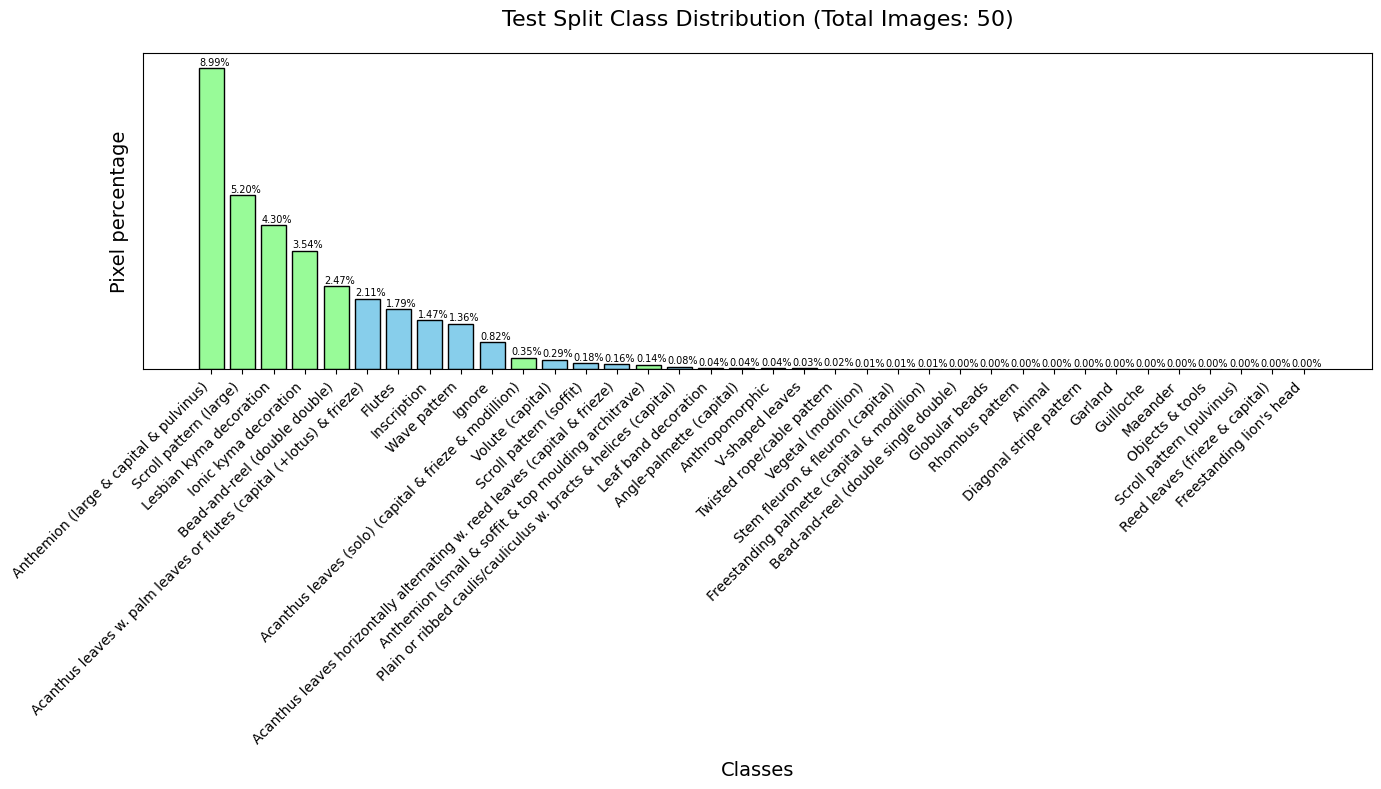

The percentage background pixels: 66.5442274989728 %


In [10]:
classes_pixel_count, total_pixels = calculate_pixel_distribution(resize_shape=None, num_classes=37)

plot_histogram(classes_pixel_count, total_pixels, 'Test Split Class Distribution') 

print_percentage_background_pixels(classes_pixel_count, total_pixels)

**Uncomment following code when using Stratified random sampling**

In [11]:
# # Read splits from csv
# print('Reading data splits...')
# df_train = pd.read_csv('data_splits/least_freq_label/train.csv')
# df_val = pd.read_csv('data_splits/least_freq_label/val.csv')
# df_test = pd.read_csv('data_splits/least_freq_label/test.csv')

# # should be strings
# X_train = df_train['id'].values.astype(str)
# X_val = df_val['id'].values.astype(str)
# X_test = df_test['id'].values.astype(str)

# print('Train Size   : ', X_train)

# # Print sizes of the splits
# print(f"Train set: {df_train.shape}")
# print(f"Validation set: {df_val.shape}")
# print(f"Test set: {df_test.shape}")

Image Size (722, 1160, 4)
Mask Size (722, 1160)


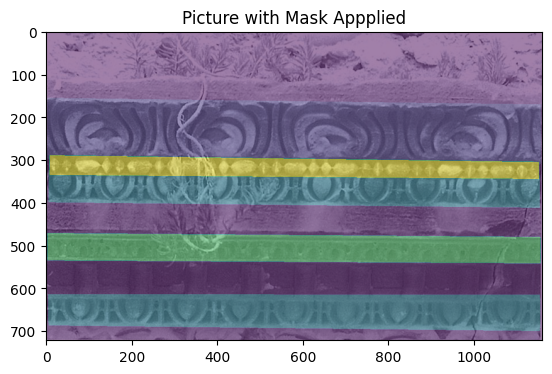

In [12]:
img = Image.open(IMAGE_PATH + df['id'][50] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][50] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title('Picture with Mask Appplied')
plt.show()

In [13]:
class ArchaeologyTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, data, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.data = data
        self.transform = transform
      
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = cv.imread(self.img_path + self.data[idx] + '.jpg')
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.mask_path + self.data[idx] + '.png', cv.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [14]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1) # output is logit, we need to pass it through softmax
        correct = torch.eq(output, mask).int() # compare output and mask, berekent element-wise gelijkheid
        accuracy = float(correct.sum()) / float(correct.numel()) # numel = number of elements in de tensor
    return accuracy

In [15]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=37):
    """
        Berekent voor elk patroon de gemiddelde IoU.
    """
    with torch.no_grad():
        pred_mask = torch.argmax(F.softmax(pred_mask, dim=1), dim=1) # softmax: om logits --> probabilities

        # 1D array
        pred_mask = pred_mask.contiguous().view(-1) 
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        # Skip the background class (0)
        for class_idx in range(1, n_classes): 
            # Binary array maken voor IoU berekening
            pred_class = (pred_mask == class_idx) 
            true_class = (mask == class_idx) 
            
            if true_class.long().sum().item() == 0: 
                iou_per_class.append(np.nan) 
            else:
                # IOU = (A ∩ B) / (A ∪ B)
                intersect = torch.logical_and(pred_class, true_class).sum().float().item() # telt aantal trues en geeft waarde terug
                union = torch.logical_or(pred_class, true_class).sum().float().item()

                iou = (intersect + smooth) / (union + smooth) # smooth om deling door 0 te voorkomen
                iou_per_class.append(iou)
                
        # Average over all classes, leaves out the nan values
        return np.nanmean(iou_per_class)

In [16]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)]) # Normaliseer de afbeelding
    image = t(image)
    model.to(device) 
    mask = mask.to(device); image=image.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0) # voeg een extra dimensie toe
        mask = mask.unsqueeze(0)   
        output = model(image)
        score = mIoU(output, mask) 
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [17]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)]) 
    image = t(image) # Normaliseer de afbeelding
    image = image.to(device); mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0) # voeg een extra dimensie toe, want het model verwacht een batch
        mask = mask.unsqueeze(0)

        output = model(image)

        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)

        masked = masked.cpu().squeeze(0) # verwijder de extra dimensie

    return masked, acc

### Load model checkpoint and dataset

In [18]:
# Model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = sm.UnetPlusPlus('resnet18', encoder_weights='imagenet', classes=37, activation=None)
model = sm.Segformer('mit_b2', encoder_weights='imagenet', classes=37, activation=None)

model.to(device)

# Load the best model
model_path = 'runs/512x512/segformer_mit_b2/best_model_epoch.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

# Creating the test dataset
# t_test = A.Compose([A.LongestMaxSize(max_size=max(512, 512)), 
#                        A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv.BORDER_CONSTANT, value=0)])

t_test = A.Resize(512, 512, interpolation=cv.INTER_NEAREST)

test_set = ArchaeologyTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

/tmp/ipykernel_8110/3813902885.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [19]:
# Read class names
import json

with open('obj_class_to_machine_color.json', 'r') as f:
    classes = json.load(f)

# List of classes
class_labels = ["background"]
class_labels.extend(list(classes.keys()))

print(class_labels)
print(len(class_labels))

['background', 'Lesbian kyma decoration', 'Anthemion (large & capital & pulvinus)', 'Angle-palmette (capital)', 'Volute (capital)', 'Twisted rope/cable pattern', 'Ionic kyma decoration', 'Leaf band decoration', 'Rhombus pattern', 'Globular beads', 'Inscription', 'Ignore', 'Scroll pattern (large)', 'Bead-and-reel (double single double)', 'Scroll pattern (soffit)', 'Bead-and-reel (double double)', 'Flutes', 'Animal', 'Anthropomorphic', 'Diagonal stripe pattern', 'Freestanding palmette (capital & modillion)', 'Garland', 'Guilloche', 'Maeander', 'Objects & tools', 'Plain or ribbed caulis/cauliculus w. bracts & helices (capital)', 'Scroll pattern (pulvinus)', 'Vegetal (modillion)', 'Wave pattern', 'Acanthus leaves (solo) (capital & frieze & modillion)', 'Anthemion (small & soffit & top moulding architrave)', 'Stem fleuron & fleuron (capital)', 'Reed leaves (frieze & capital)', 'Acanthus leaves w. palm leaves or flutes (capital (+lotus) & frieze)', 'Acanthus leaves horizontally alternating w

In [20]:
# Class colors
with open('class_colors.json', 'r') as f:
    classes = json.load(f)

classes = classes['classes'] 

# background is alpha 0
class_colors = ['#E0E0E0'] # background color

for i in classes:
    class_colors.append(i['color'])

print(class_colors)
print(len(class_colors))

['#E0E0E0', '#D5F651', '#2A40AC', '#2BA186', '#1B8AD0', '#589933', '#F3871B', '#2EFA6B', '#0A8F67', '#C06762', '#20BC66', '#4EE9E1', '#000000', '#FC19B3', '#055EB8', '#AC3535', '#F5A623', '#EB0F97', '#F8E71C', '#F7826E', '#6594F1', '#32C22E', '#4549BF', '#DA626A', '#778CC5', '#00A39E', '#9013FE', '#24C2B1', '#4AF77B', '#A4133A', '#975B07', '#FF0079', '#FE0000', '#B95C5C', '#02C2FF', '#AA1608', '#77B337']
37


In [21]:
all_data = ArchaeologyTestDataset(IMAGE_PATH, MASK_PATH, df['id'].values, transform=t_test)

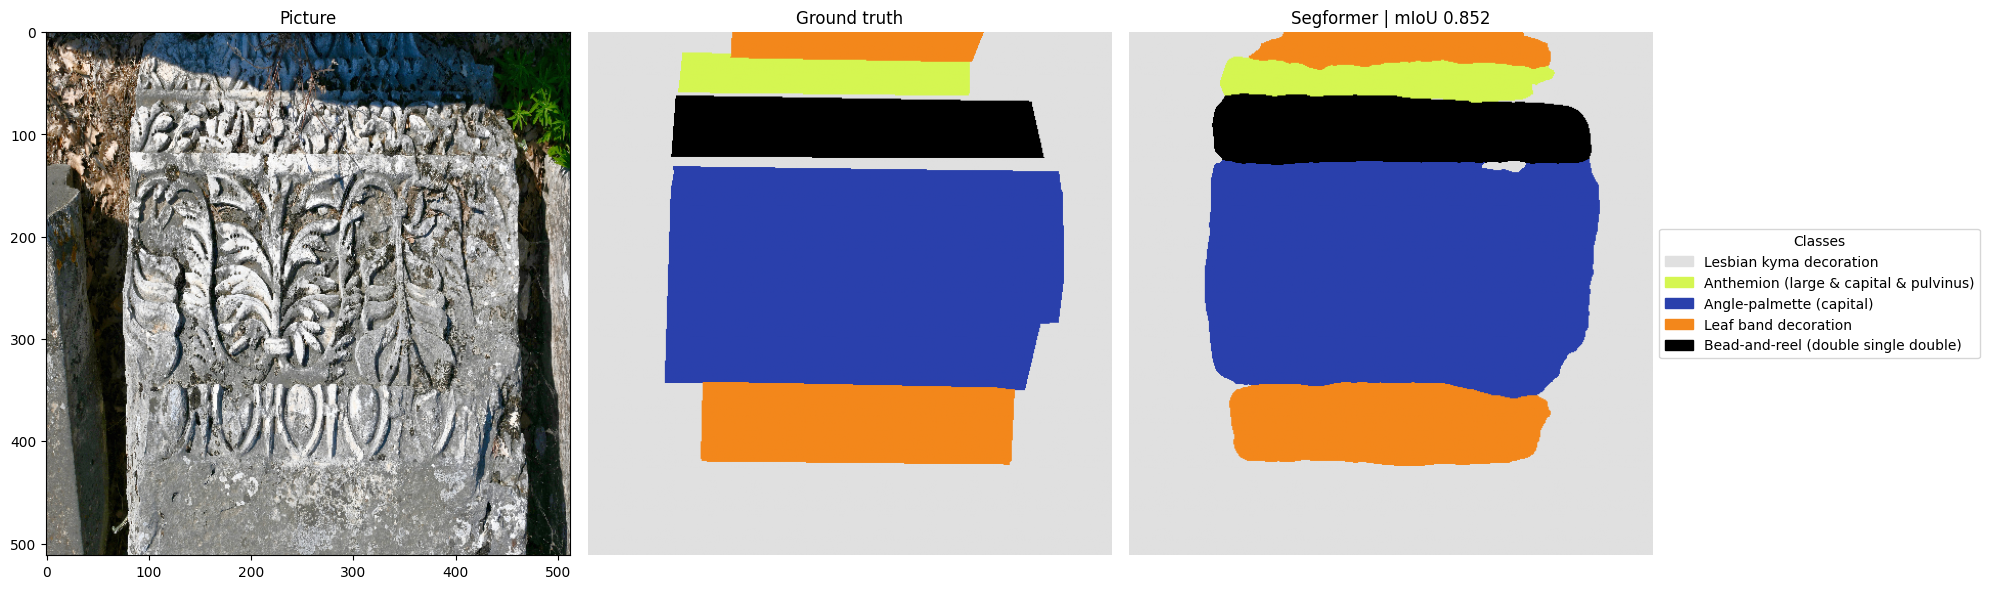

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

image_id = 489

image, mask = all_data[image_id]

pred_mask, score = predict_image_mask_miou(model, image, mask)

# Determine unique classes in the mask and the predicted mask
unique_classes = np.concatenate((np.unique(mask), np.unique(pred_mask)))
unique_classes = np.unique(unique_classes) # remove duplicates
unique_colors = np.array(class_colors)[unique_classes] # Kleuren van Supervisely selecteren

cmap = ListedColormap(unique_colors)

class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes)} # class and rgb color

# Prepare colors for the masks
colored_mask = np.zeros((*mask.shape, 3))
colored_pred_mask = np.zeros((*pred_mask.shape, 3))

for cls in unique_classes:
    colored_mask[mask == cls] = class_to_color[cls][:3]  # Ignore alpha
    colored_pred_mask[pred_mask == cls] = class_to_color[cls][:3]  # Ignore alpha

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(colored_mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(colored_pred_mask)    
ax3.set_title('Segformer | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

# Define a legend with class names and corresponding colors
patches = [
    mpatches.Patch(color=class_to_color[cls], label=class_labels[cls])
    for cls in unique_classes
]

ax3.legend(
    handles=patches,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Classes"
)

plt.tight_layout()
plt.show()

In [23]:
# plot all image predictions with legends
def show_predictions(image_number, title="Segformer mit_b2"):
    image, mask = test_set[image_number] # get the first image and mask

    pred_mask, score = predict_image_mask_miou(model, image, mask)

    # Determine unique classes in the mask and the predicted mask
    unique_classes = np.concatenate((np.unique(mask), np.unique(pred_mask)))
    unique_classes = np.unique(unique_classes) # remove duplicates
    unique_colors = np.array(class_colors)[unique_classes] # Kleuren van supervisely selecteren

    # Prepare colors for the masks
    cmap = ListedColormap(unique_colors)

    class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes)}
    print(class_to_color)

    # Prepare colors for the masks
    colored_mask = np.zeros((*mask.shape, 3))
    colored_pred_mask = np.zeros((*pred_mask.shape, 3))


    for cls in unique_classes:
        colored_mask[mask == cls] = class_to_color[cls][:3]  # Ignore alpha
        colored_pred_mask[pred_mask == cls] = class_to_color[cls][:3]  # Ignore alpha

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Picture')

    ax2.imshow(colored_mask)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(colored_pred_mask)    
    ax3.set_title(title + ' | mIoU {:.3f}'.format(score))
    ax3.set_axis_off()

    # Define a legend with class names and corresponding colors
    patches = [
        mpatches.Patch(color=class_to_color[cls], label=class_labels[cls])
        for cls in unique_classes
    ]

    ax3.legend(
        handles=patches,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        title="Classes"
    )

    plt.tight_layout()
    plt.savefig('results/' + str(image_number) + '.png')
    plt.show()

In [24]:
##########################
## SHOW ALL PREDCITIONS ##
##########################

# for i in range(len(test_set)):
#     show_predictions(i)

# Evaluate

In [25]:
# Read classes json
import json

with open('obj_class_to_machine_color.json', 'r') as f:
    classes = json.load(f)

# List of classes
class_labels = list(classes.keys())

print(len(class_labels))

important_classes = [
        'Ionic kyma decoration', 
        'Lesbian kyma decoration', 
        'Bead-and-reel (double double)', 
        'Scroll pattern (large)', 
        'Anthemion (large & capital & pulvinus)', 
        'Anthemion (small & soffit & top moulding architrave)', 
        'Acanthus leaves (solo) (capital & frieze & modillion)'
    ]

labels_import_classes = [6, 1, 15, 12, 2, 30, 29]

36


In [26]:
"""
    Go through the test set and do inference on each image. 
    Create and one big array with all predictions and ground truth.
"""
# Mean and standard deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms
t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

model.eval()

gt_labels = []
pred_labels = []

iou_per_class = np.zeros(n_classes)

# Loop through the test dataset and create 1D array
for i in tqdm(range(len(test_set))):
    img, mask = test_set[i]  # img is a PIL image

    # Apply transformations to img
    img = t(img)             
    img = img.to(device)     
    mask = mask.to(device, dtype=torch.long)  # Ensure mask is long type

    # Generate prediction
    with torch.no_grad():
        output = model(img.unsqueeze(0))  # Add batch dimension
        pred_mask = torch.argmax(output, dim=1)  # Predicted class indices
        
    # Flatten predictions and ground truth
    pred_mask = pred_mask.squeeze().cpu().numpy()
    mask = mask.cpu().numpy()
    
    # One big array for all predictions and ground truth
    pred_labels.extend(pred_mask.flatten())
    gt_labels.extend(mask.flatten())

# Convert to numpy arrays
pred_labels = np.array(pred_labels)
gt_labels = np.array(gt_labels)

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [00:43<00:55,  1.99s/it]


KeyboardInterrupt: 

Support telt hoe veel pixels een bepaalde klasse bevatten. 

In [105]:
print(classification_report(gt_labels, pred_labels, labels=labels_import_classes, target_names=important_classes, zero_division=0))

                                                       precision    recall  f1-score   support

                                Ionic kyma decoration       0.84      0.84      0.84    660050
                              Lesbian kyma decoration       0.93      0.84      0.88    595204
                        Bead-and-reel (double double)       0.89      0.87      0.88    450258
                               Scroll pattern (large)       0.98      0.83      0.90    420412
               Anthemion (large & capital & pulvinus)       0.90      0.95      0.93    808998
 Anthemion (small & soffit & top moulding architrave)       0.94      0.49      0.64    199203
Acanthus leaves (solo) (capital & frieze & modillion)       0.93      0.92      0.93    428382

                                            micro avg       0.91      0.86      0.88   3562507
                                            macro avg       0.92      0.82      0.86   3562507
                                         weighte

In [106]:
report = classification_report(gt_labels, pred_labels, labels=labels_import_classes, target_names=important_classes, zero_division=0, output_dict=True)

In [107]:
report = classification_report(gt_labels, pred_labels, labels=labels_import_classes, target_names=important_classes, zero_division=0, output_dict=True)

In [108]:
mean_iou = jaccard_score(gt_labels, pred_labels, labels=labels_import_classes, average="macro", zero_division=0)

print(f"IoU for each class (macro): \n {mean_iou}")

IoU for each class (macro): 
 0.7592535483710756


In [109]:
mean_iou = jaccard_score(gt_labels, pred_labels, labels=labels_import_classes, average="weighted", zero_division=0)

print(f"IoU for each class (weighted): \n {mean_iou}")

IoU for each class (weighted): 
 0.7876796045077675


In [110]:
ious_important_classes = {}

# Loop through the important classes and calculate the IoU
for i in range(len(labels_import_classes)):
    idx = int(labels_import_classes[i])
    iou = jaccard_score(gt_labels, pred_labels, labels=[idx], average=None, zero_division=0)
    ious_important_classes[important_classes[i]] = iou

print(ious_important_classes)

{'Ionic kyma decoration': array([0.72534687]), 'Lesbian kyma decoration': array([0.78841034]), 'Bead-and-reel (double double)': array([0.78327055]), 'Scroll pattern (large)': array([0.81672006]), 'Anthemion (large & capital & pulvinus)': array([0.86193732]), 'Anthemion (small & soffit & top moulding architrave)': array([0.47515837]), 'Acanthus leaves (solo) (capital & frieze & modillion)': array([0.86393133])}


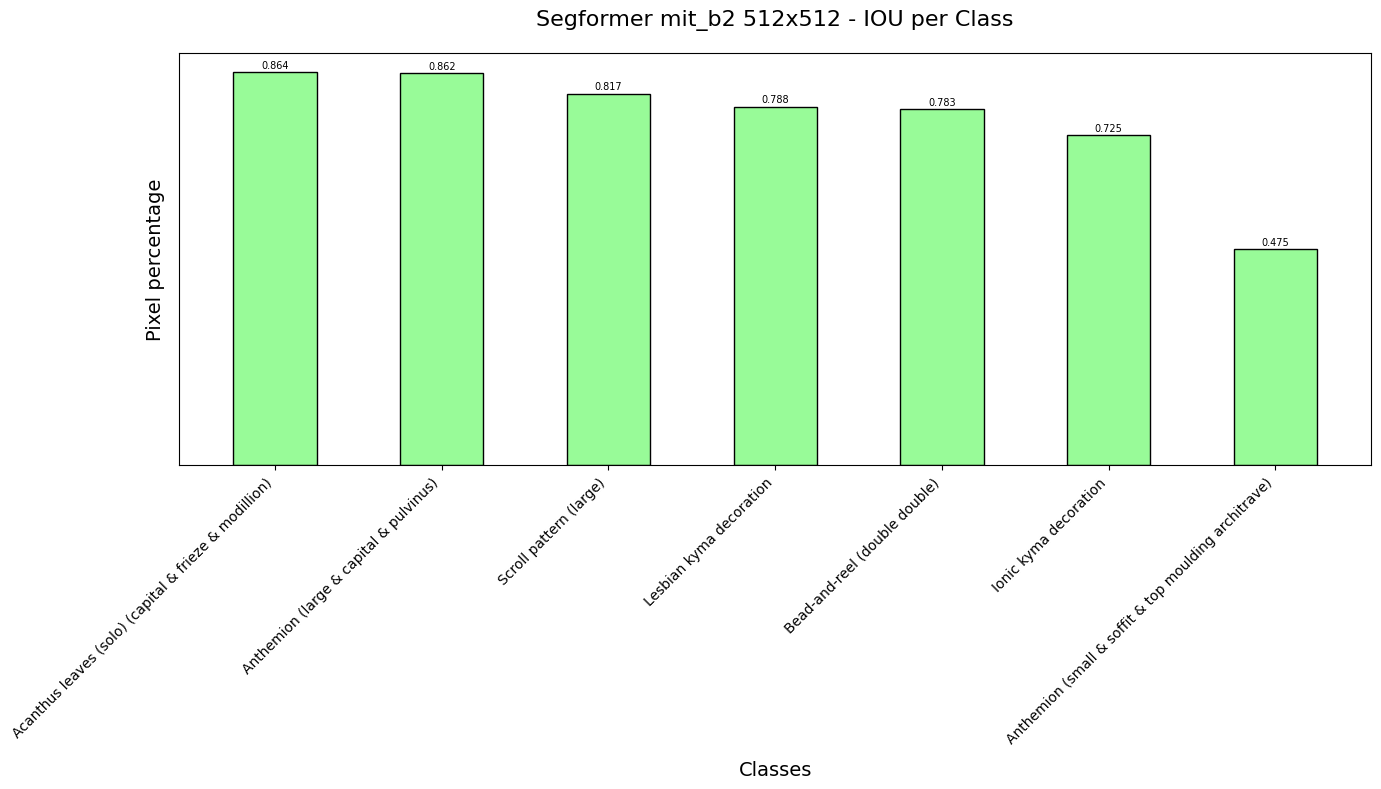

In [111]:
class_pixel_dict = dict(sorted(ious_important_classes.items(), key=lambda item: item[1], reverse=True)) # Sorteer op pixel count

classes = list(class_pixel_dict.keys())
iou_values = [value[0] for value in class_pixel_dict.values()]  # Extract scalar from array

 # Maak histogram
plt.figure(figsize=(14, 8))
plt.bar(classes, iou_values, width=0.5, color='palegreen', edgecolor='black')
    
# Add labels and title
plt.xlabel('Classes', fontsize=14, labelpad=10)
plt.ylabel('Pixel percentage', fontsize=14, labelpad=10)

plt.title(f'Segformer mit_b2 512x512 - IOU per Class', fontsize=16, pad=20)
    
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate class labels for better visibility
plt.yticks([])
    
# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
    
# Annotate bars with IOU
for i, iou in enumerate(iou_values):
    plt.text(i, iou + 0.01, f'{iou:.3f}', ha='center', fontsize=7, color='black')
    
# Display the plot
plt.tight_layout()
plt.savefig('iou_per_class.png')
plt.show()

Classification Report:


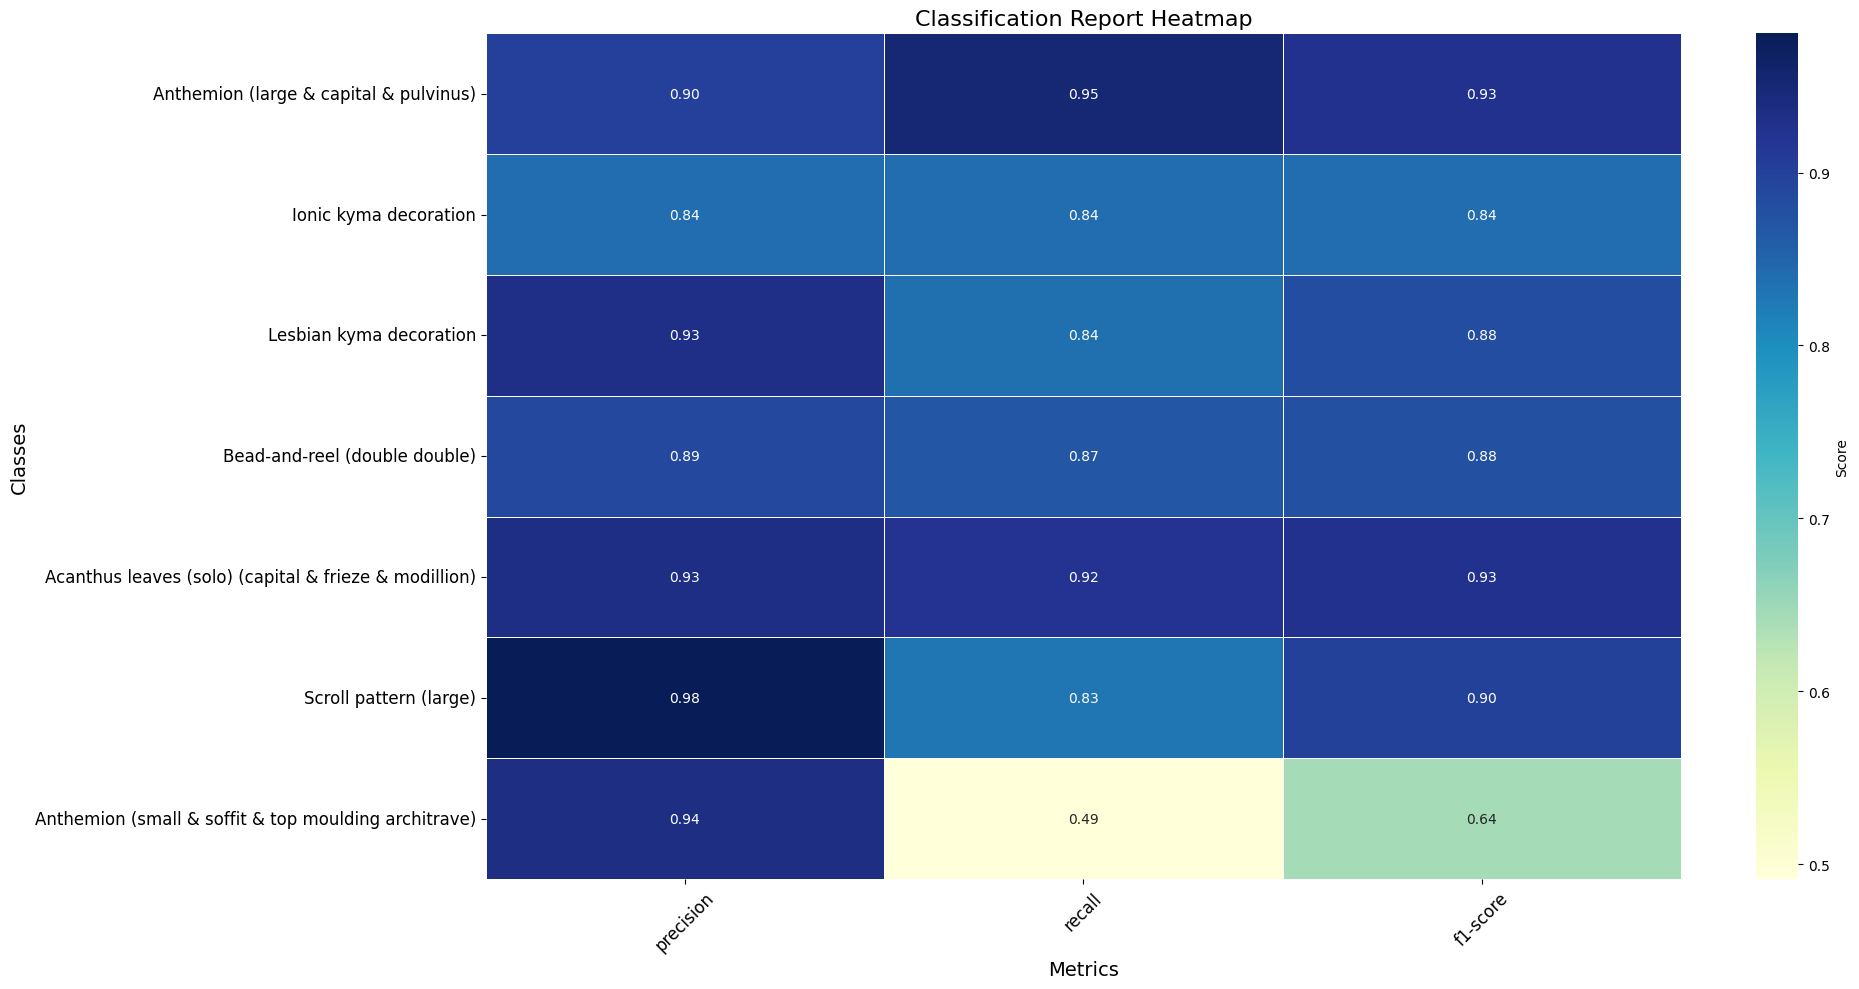

In [112]:
import seaborn as sns

# Generate classification report
print("Classification Report:")

# There are 37 classes, so we need to specify the labels
report = classification_report(gt_labels, pred_labels, labels=labels_import_classes, target_names=important_classes, zero_division=0, output_dict=True)
df_report = pd.DataFrame(report).transpose()

heatmap_data = df_report.iloc[:-3, :]  # Exclude 'accuracy' and average rows/columns

# Sort 
# heatmap_data = heatmap_data.sort_values(by="precision", ascending=False)
heatmap_data = heatmap_data.sort_values(by="support",  ascending=False)
heatmap_data = heatmap_data.drop(columns=["support"])  # Drop support column

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap="YlGnBu", 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={'label': 'Score'}
)
plt.title("Classification Report Heatmap", fontsize=16)
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Classes", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig("classification_report_best_classes.png")
plt.show()